#### In this routine, some changes were made by Mustafa Bünyamin Sağman.
#### If you have any problem, just send an e-mail to mbunyamins@gmail.com

In [1]:
def compute_iou(box, boxes, box_area, boxes_area):

    y1 = np.maximum(box[0], boxes[:, 0])
    y2 = np.minimum(box[2], boxes[:, 2])
    x1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[3], boxes[:, 3])
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    union = box_area + boxes_area[:] - intersection[:]
    iou = intersection / union
    return iou



def compute_overlaps(boxes1, boxes2):

    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])


    overlaps = np.zeros((boxes1.shape[0], boxes2.shape[0]))
    for i in range(overlaps.shape[1]):
        box2 = boxes2[i]
        overlaps[:, i] = compute_iou(box2, boxes1, area2[i], area1)
    return overlaps

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pandas as pd
import time
import cv2
import os
from tqdm import tqdm
import csv
import seaborn as sn


## Requirements: 
#### -To evaluate any model, bounding boxes of ground truths and predictions must be provided in seperate text files. 
#### -The rows must be ordered by image ids
#### -Exact format format of the text files should be like this:
#### -image_id,class_id,bounding_box_coordinates(y1,x1,y2,x2). Example:
####  0,1,[216 400 656 644]
####  1,44,[319 672 837 978]
####  2,1,[435 150 670 250]



###  ---**To obtain quick evaluations** on COCO groundtruths, all that is needed to be changed is "preds.txt" file in vallogs directory.

### 1) Set Directories to where you put your text files in. 

In [3]:
train_dir = "trainlogs"
val_dir = "vallogs"
prediction_file = "predsCOCO25.txt"
gtruth_file = "gt.txt"

#### Total image numbers to be evaluated:

In [4]:
valTxt = open((val_dir + "/" + gtruth_file), "r")
lines = valTxt.readlines()
val_total_image = (int(lines[-1].split(",")[0]) + 1)
print(val_total_image)

trainTxt = open((train_dir + "/" + gtruth_file), "r")
Tlines = trainTxt.readlines()
train_total_image = (int(Tlines[-1].split(",")[0]) + 1)
print(train_total_image)

40137
82081


####  Class Names as in the original dataset. Default one is for COCO

In [5]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter',
               'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase',
               'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
               'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
               'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
               'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

#### Text reading function

In [6]:
import csv

def text_reader(folder,name):
    print("Reading the file:")
    predictionlist=[]
    with open(os.path.join(folder, name),newline = '') as f:
        rows = csv.reader(f)
        for row in rows:
            predictionlist.append(row)
    predictions = []
    for i in tqdm(range(len(predictionlist))):
        img_id = eval(predictionlist[i][0])
        class_id = eval(predictionlist[i][1])
        bbox = (predictionlist[i][2][1:-1]).split(' ')
        j_list = []
        for i in bbox:
            k = []
            if not i == '':
                   j_list.append(i)
        bbox=[eval(i) for i in j_list]
        predictions.append([img_id, class_id, bbox])
    return predictions

### **We must set our target** ("train" or "val")

In [7]:
target = "val" 

In [8]:
if (target == "train"):
    directory = train_dir
    total_image = train_total_image
elif (target == "val"):
    directory = val_dir
    total_image = val_total_image
else:
    print("Choose 'train' or 'val' please")

print(total_image)
print(directory)

40137
vallogs


### Read GT and Prediction files.

In [9]:
preds = text_reader(directory, prediction_file)


Reading the file:


100%|██████████| 154415/154415 [00:05<00:00, 30453.84it/s]


In [10]:
first = [0, 1, [2, 2, 1, 1]]
last = [(total_image - 1), 1, [2, 2, 1, 1]]
if(not preds[0][0] == 0):
    preds.insert(0,first)

if(not preds[-1][0] == (total_image - 1)):
    preds.append(last)

In [11]:
gts = text_reader(directory, gtruth_file)

Reading the file:


100%|██████████| 291875/291875 [00:09<00:00, 30472.86it/s]


In [12]:
def get_container(liste, upto):
    last_n = 0
    container = []
    for index,row in enumerate(liste[:upto]):
        if row[0] == last_n:
            continue
        else:   
            container.append([last_n, index])
            last_n = row[0]
    container.append([liste[-1][0], len(liste)])
    return container

In [13]:
gt_container = get_container(gts, len(gts))

In [14]:
pred_container = get_container(preds, len(preds))

In [15]:
keyp = 0
def load_boxes(im_id, container, datas, val = False):
    global keyp
    if val == True:
        key = keyp
    elif val == False:
        key = 0
    if(im_id != container[im_id - key][0]):
        #print("No predictions in image:"+str(im_id))
        keyp += 1
        return [[0,0,0,0]], ['BG']
    last = container[im_id-key][1]
    assert im_id >= 0
    if im_id >0:
        first = container[im_id - 1 - key][1]
    else:
        first=0
    class_id_list = []
    box_list = []
    
    for data in datas[first:last]:
        class_id = data[1]
        box = data[2]
        class_id_list.append(class_id)
        box_list.append(box)
    if box_list[0][2] - box_list[0][0] < 0:
        for i in range(len(box_list)):
            box = box_list[i]
            inverted_box = [box[2], box[1], box[0], box[3]]
            box_list[i] = inverted_box
            
    return box_list, class_id_list
    
    
    
    

In [16]:
keyp = 0
predbxz,_ = load_boxes(56, pred_container, preds, val = True)
gtbxz,_ = load_boxes(56, gt_container, gts)

In [17]:
def evaluate(size, threshold, gt_container, pred_container, preds,gts):
    gtruths = []
    predictions = []
    preda_bbxx = []
    for i in tqdm(range(size)):
        preda_bbx, pred_classes = load_boxes(i, pred_container, preds, val = True)
        gta_bbx, gt_classes = load_boxes(i, gt_container, gts)
        overlaps = compute_overlaps(np.array(preda_bbx), np.array(gta_bbx))
        preda_bbxx.append([i, preda_bbx])
        match_count = 0
        
        try:
            for  j in range(overlaps.shape[1]):
                if overlaps.shape[0] > 0:
                    if overlaps[(overlaps[:, j].argmax()), j] > threshold:
                        gtruths.append((gt_classes[j]))
                        predictions.append(pred_classes[overlaps[:, j].argmax()])

        except:
            print(overlaps.shape[0], overlaps.shape[1])
    return gtruths, predictions, preda_bbxx

In [18]:
keyp = 0
iou_threshold = 0.2
a, s, bbx = evaluate(total_image, iou_threshold, gt_container, pred_container, preds,gts)

 64%|██████▍   | 25832/40137 [00:03<00:01, 7514.74it/s]/home/mspr/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
100%|██████████| 40137/40137 [00:05<00:00, 7516.94it/s]


In [19]:
cfmatrix = confusion_matrix(a, s)

#### Normalised Confusion Matrix

In [20]:
def percentage_plot_cfmatrix(confusion_matrix, class_names ,threshold,figsize = (40, 40), fontsize = 8):
    confusion_matrix = cfmatrix / cfmatrix.sum(axis = 1, keepdims = True)
    df_cm = pd.DataFrame(
        (100 * confusion_matrix), index = class_names[1:], columns = class_names[1:], 
    )
    fig = plt.figure(figsize = figsize)
    try:
        heatmap = sn.heatmap(df_cm, annot = True, cmap = "YlGnBu", fmt = '.1f',annot_kws = {"size": 10})
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 90, ha = 'right', fontsize = fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("ConfusionMatrix-Face@threshold:" + str(threshold) + ".png")
    return fig

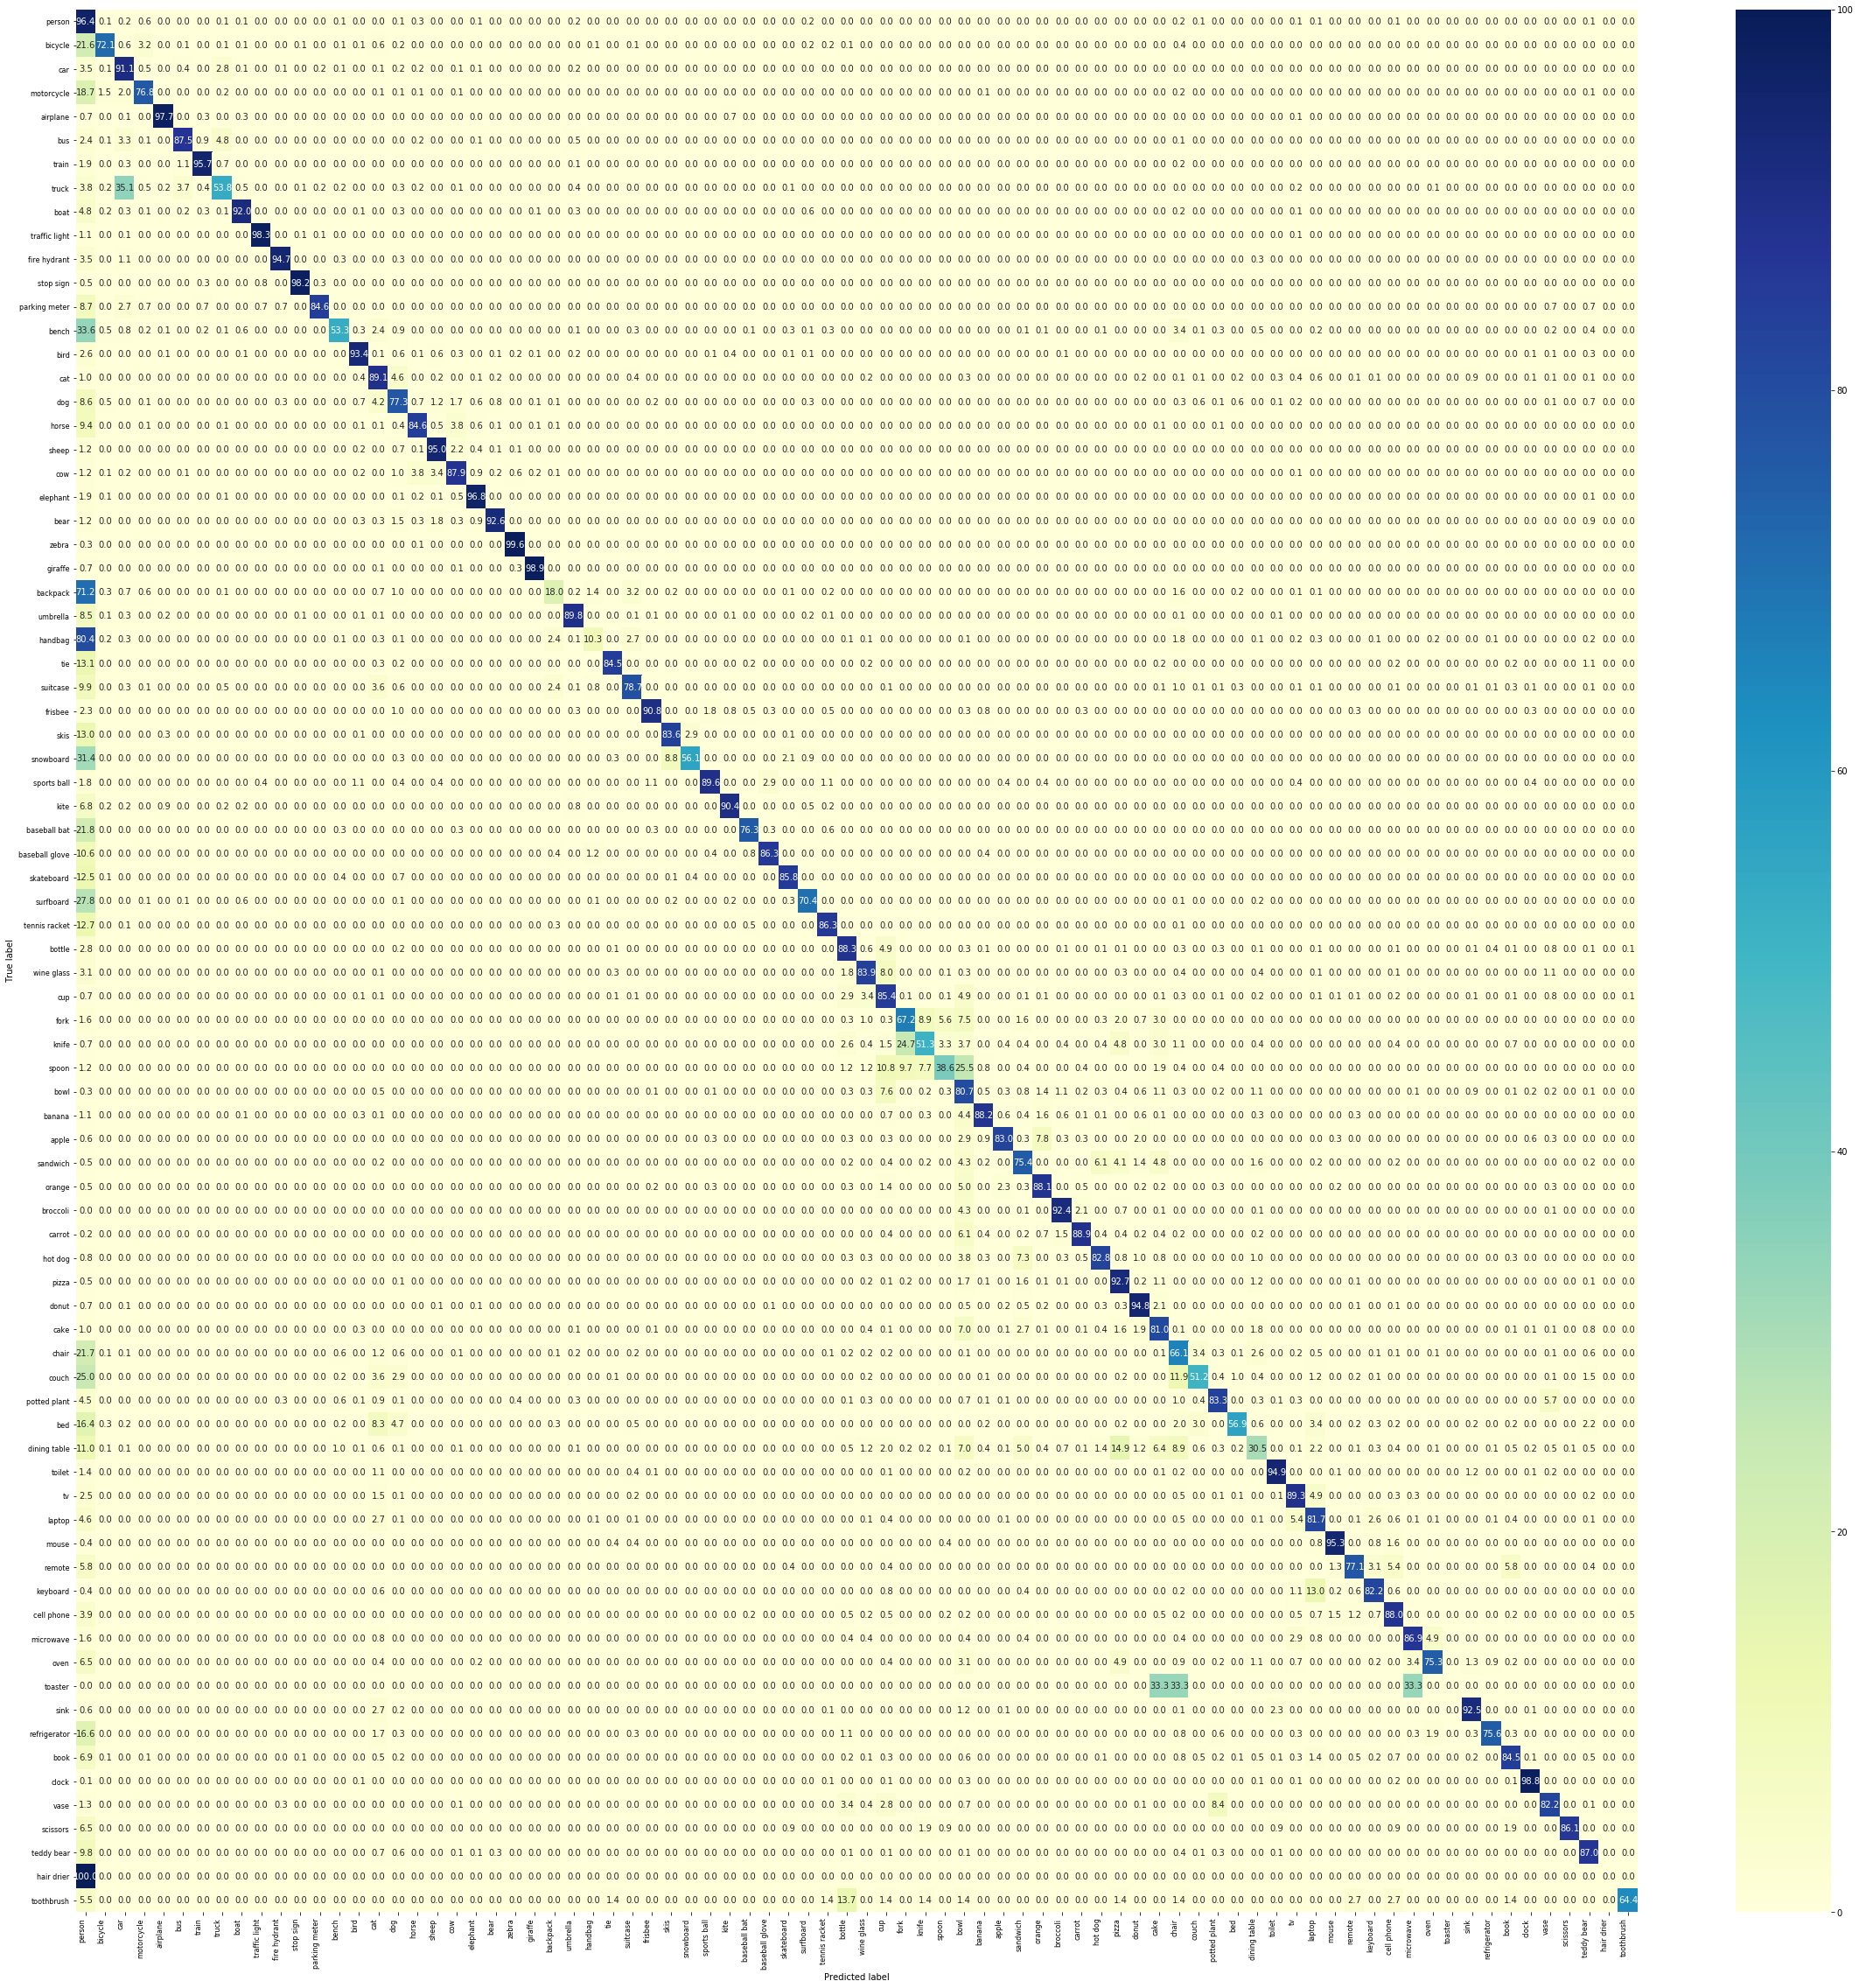

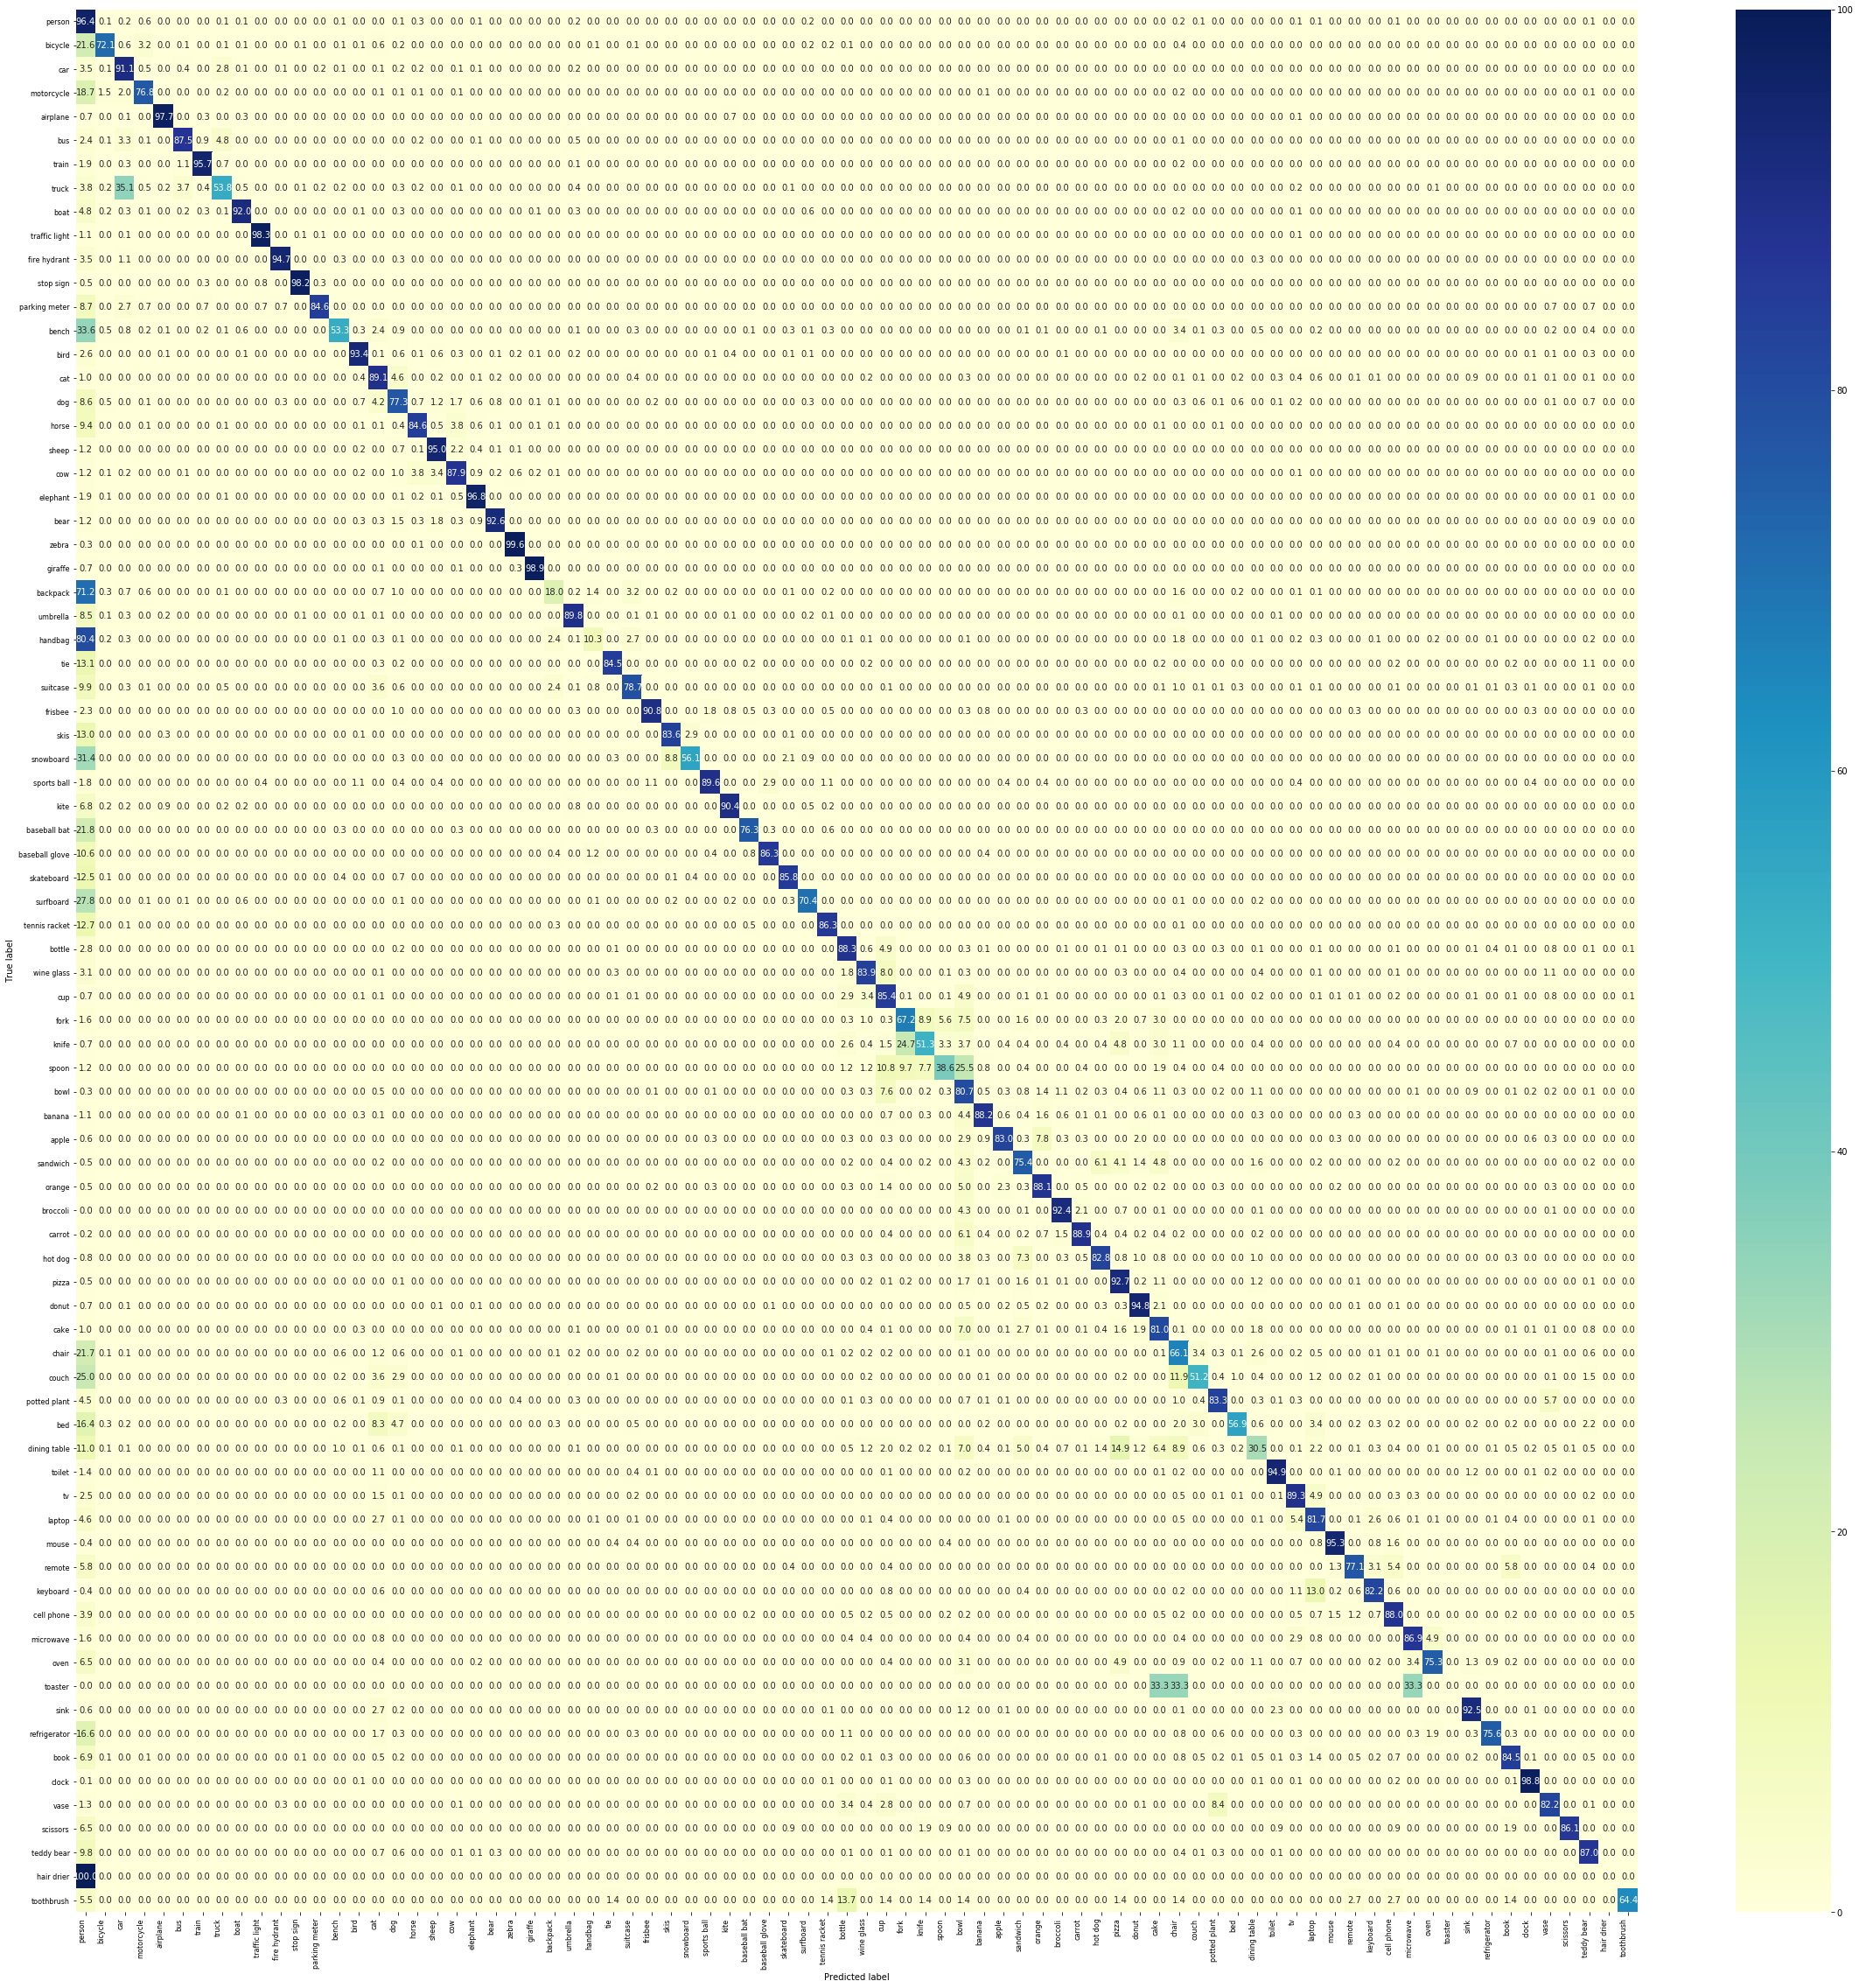

In [21]:
percentage_plot_cfmatrix(cfmatrix, class_names, iou_threshold)

### Part that calculates Missed instances, false positives etc.:

In [22]:
def elob(size, threshold, gt_container, pred_container, preds, gts, class_names):
    gtruths = []
    predictions = []
    all_gt_classes = {i:0 for i in class_names}
    class_matrix = {i:[0,0,0,0] for i in class_names}
    miss_matrix = {k:[0] for k in class_names}
    for i in tqdm(range(size)):
        preda_bbx, pred_classes = load_boxes(i, pred_container, preds, val = True)
        gta_bbx, gt_classes = load_boxes(i, gt_container, gts)
        overlaps = compute_overlaps(np.array(preda_bbx), np.array(gta_bbx))
        
        match_count = 0
    
        for  j in range(overlaps.shape[1]):
            all_gt_classes[class_names[gt_classes[j]]] += 1
            if overlaps.shape[0] > 0:
                if overlaps[(overlaps[:, j].argmax()),j] > threshold:
                    gtruths.append((gt_classes[j]))
                    predictions.append(pred_classes[overlaps[:, j].argmax()])
                    match_count += 1
                    ### FALSE NEGATIVE

                    
                    if gt_classes[j] != pred_classes[overlaps[:, j].argmax()]:       ## MATCHED BUT WRONG PREDICTION
                        class_matrix[class_names[gt_classes[j]]][0] += 1
                    else:                        
                        class_matrix[class_names[gt_classes[j]]][1] += 1            ##TRUE POS
                ##FALSE NEGATIVE
                elif overlaps[(overlaps[:, j].argmax()),j] < threshold:
                    #class_matrix[class_names[gt_classes[j]]][0]+=1
                    class_matrix[class_names[gt_classes[j]]][3]+=1                ## MİSS
        #FALSE POS
        if i == 56:
            print(match_count)
        if overlaps.shape[0] > 0:
            for k in range(overlaps.shape[0]):
                if overlaps[k,overlaps[k,:].argmax()] < threshold and pred_classes[k] != 'BG':    ## FALSE POS
                    class_matrix[class_names[pred_classes[k]]][2] += 1            

    return gtruths, predictions, class_matrix, all_gt_classes

###  -Change Intersection of Union Threshold below

In [23]:
keyp = 0
iou_threshold = .5
a, s, class_matrix, all_gts = elob(total_image, iou_threshold, gt_container, pred_container, preds, gts, class_names)

  3%|▎         | 1184/40137 [00:00<00:06, 5906.68it/s]

7


 65%|██████▍   | 25925/40137 [00:03<00:02, 6749.59it/s]/home/mspr/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
100%|██████████| 40137/40137 [00:05<00:00, 6768.55it/s]


In [24]:
pframe = pd.DataFrame.from_dict(class_matrix)
pframe

,BG,airplane,apple,backpack,banana,baseball bat,baseball glove,bear,bed,bench,...,toilet,toothbrush,traffic light,train,truck,tv,umbrella,vase,wine glass,zebra
0,0,3,20,91,9,13,3,16,96,79,...,18,3,2,12,249,39,15,32,31,4
1,0,517,179,88,299,107,27,274,319,357,...,809,33,163,795,554,848,810,383,315,1106
2,0,427,426,285,617,359,391,140,66,407,...,694,41,1113,247,753,1057,1495,597,732,878
3,0,925,1583,2712,2617,902,1176,172,1035,3064,...,636,598,4197,795,2534,1170,3154,1852,2292,775


### Order classes by their instance number:

In [25]:
real = pframe.reindex((pframe.iloc[0] + pframe.iloc[1] + pframe.iloc[3]).sort_values().index, axis = 1)
real

,BG,hair drier,toaster,scissors,bear,parking meter,microwave,toothbrush,fire hydrant,stop sign,...,handbag,traffic light,bowl,dining table,cup,bottle,book,chair,car,person
0,0,1,3,6,16,5,13,3,1,1,...,144,2,136,283,102,63,26,302,107,299
1,0,0,0,60,274,97,164,33,295,285,...,39,163,881,474,882,376,126,1377,1629,23211
2,0,0,0,72,140,72,230,41,200,324,...,245,1113,1712,296,2438,2311,1439,3193,6544,35287
3,0,73,75,378,172,410,362,598,354,400,...,3933,4197,3903,4487,6052,7944,8408,11455,13277,64640


In [26]:
number_of_instances = (pframe.iloc[[0, 1, 3]].sum())

In [27]:
percentage = pframe / (pframe.iloc[[0, 1, 2, 3]].sum())
percentage = percentage.drop(['BG'], axis = 1)
percentage

,airplane,apple,backpack,banana,baseball bat,baseball glove,bear,bed,bench,bicycle,...,toilet,toothbrush,traffic light,train,truck,tv,umbrella,vase,wine glass,zebra
0,0.001603,0.009058,0.028652,0.002541,0.009413,0.001879,0.026578,0.063325,0.020220,0.011051,...,0.008345,0.004444,0.000365,0.006490,0.060880,0.012524,0.002740,0.011173,0.009199,0.001448
1,0.276175,0.081069,0.027708,0.084416,0.077480,0.016907,0.455150,0.210422,0.091374,0.131986,...,0.375058,0.048889,0.029772,0.429962,0.135452,0.272319,0.147972,0.133729,0.093472,0.400290
2,0.228098,0.192935,0.089736,0.174195,0.259957,0.244834,0.232558,0.043536,0.104172,0.218819,...,0.321743,0.060741,0.203288,0.133586,0.184108,0.339435,0.273109,0.208450,0.217211,0.317771
3,0.494124,0.716938,0.853904,0.738848,0.653150,0.736381,0.285714,0.682718,0.784233,0.638143,...,0.294854,0.885926,0.766575,0.429962,0.619560,0.375723,0.576178,0.646648,0.680119,0.280492


In [28]:
non_tuned_percentage = percentage

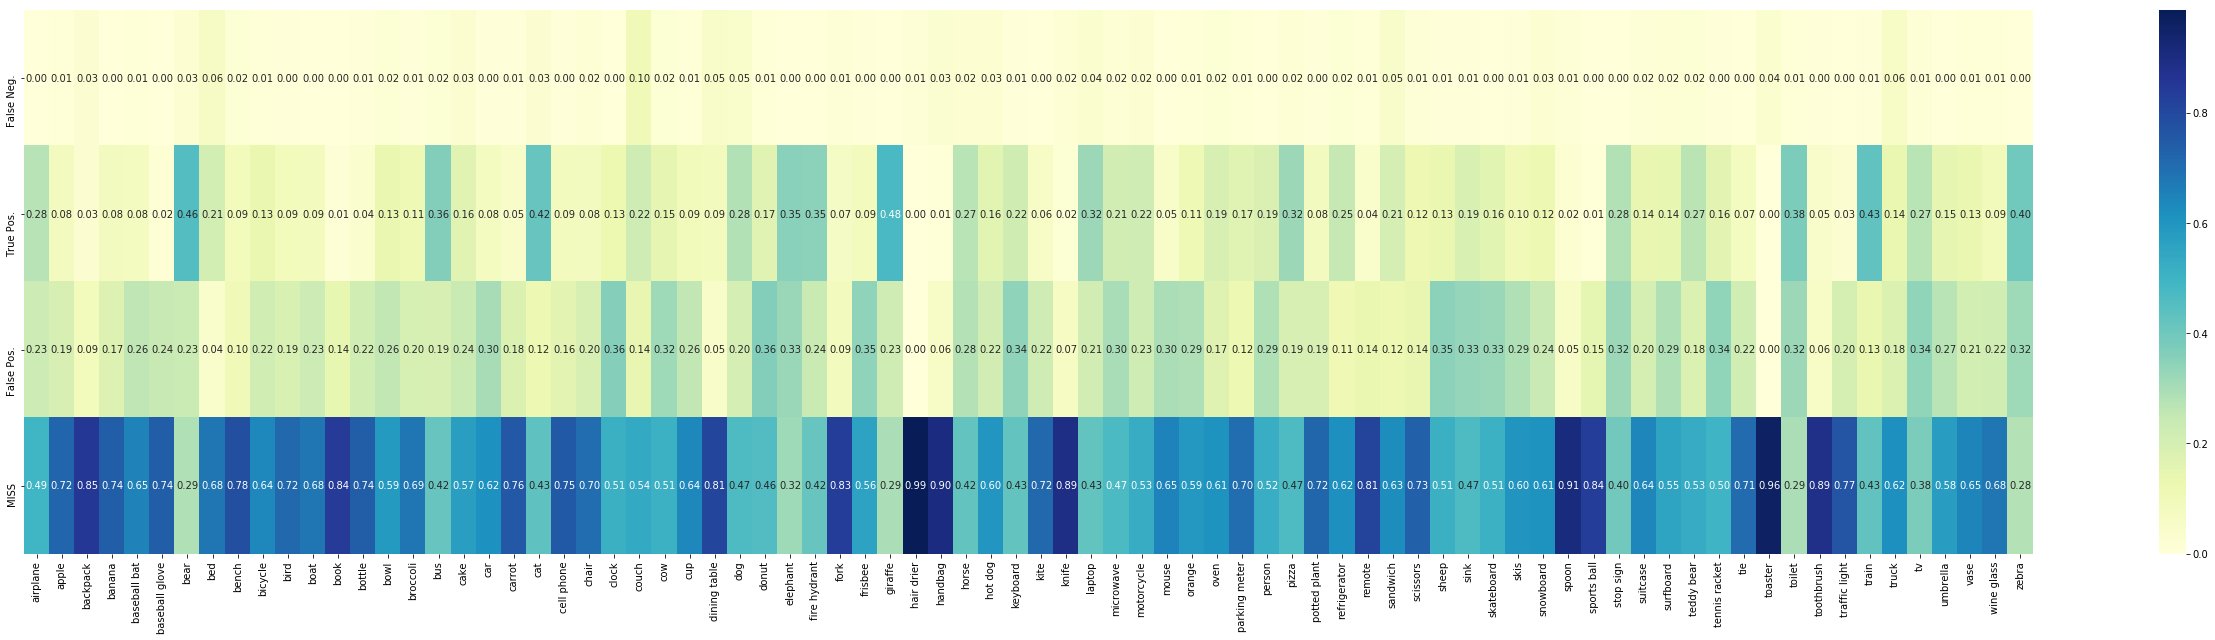

In [29]:
plt.figure(figsize = (45, 10))
heatmap = sn.heatmap(percentage, annot = True, annot_kws = {"rotation":0}, cmap = "YlGnBu", fmt = '.2f')
heatmap.yaxis.set_ticklabels(["False Neg.", "True Pos.", "False Pos.", "MISS"], rotation = 90, ha = 'right', fontsize = 10),
plt.savefig("Tuned-Table.png")

### False Positives:
####  Detection on Background.
### False Negatives:
#### -Matched locally with GT, but wrong class prediction.
#### - Fails to detect the object. 
### True Positive:
#### Matching the GT with correct class label.



### RECALL:

####  TP/(TP+FN)


### Precision:

### TP/(TP+FP)

In [30]:
def get_recall(class_matrix, class_names):
    recall = [np.nan if ((class_matrix[i][1] + class_matrix[i][0] + class_matrix[i][3]) == 0) else class_matrix[i][1] / (class_matrix[i][1] + class_matrix[i][0] + class_matrix[i][3]) for i in class_names[1:]]
    return recall

In [31]:
def get_precision(class_matrix, class_names):
    precision = [np.nan if ((class_matrix[i][1] + class_matrix[i][2]) == 0) else class_matrix[i][1] / (class_matrix[i][1] + class_matrix[i][2]) for i in class_names[1:]]
    return precision

In [32]:
def get_f1_score(precision, recall):
    F1 = [np.nan if ((precision[k] + recall[k]) == 0) else 2 * (precision[k] * recall[k]) / (precision[k] + recall[k]) for k in range(len(class_names[1:]))]
    return F1

In [33]:
def overview(threshold):
    keyp = 0
    gt, pred, class_matrix = elob(total_image, threshold, gt_container, pred_container, preds, gts, class_names)
    recall = get_recall(class_matrix, class_names)
    precision = get_precision(class_matrix, class_names)
    f1_score = get_f1_score(precision, recall)
    sn.heatmap(f1_score)
    return recall, precision, f1_score

In [34]:
def overallPerformance(class_matrix, theLastList):
    pframe = pd.DataFrame.from_dict(class_matrix)
    real = pframe.reindex((pframe.iloc[0] + pframe.iloc[1] + pframe.iloc[3]).sort_values().index, axis = 1)
    df = real.sum(axis = 1)
    recall = df[1] / (df[1] + df[3] + df[0])
    precision = df[1] / (df[1] + df[2])
    f1_score = precision * recall * 2 / (precision + recall)
    theLastList[0].append(recall)
    theLastList[1].append(precision)
    theLastList[2].append(f1_score)
    return theLastList

#### How different thresholds affects predictions:
#### Currently  IoU between 0.4-0.8

In [35]:
complete_list = [[],[],[]]
theLastList = [[],[],[]]
thresholdForLabel = []
for i_threshold in range(2, 6, 1):
    i_threshold = i_threshold / 10
    keyp = 0
    thresholdForLabel.append(str(round(i_threshold, 1)))
    a, s, class_matrix, gt_classes = elob(total_image, i_threshold, gt_container, pred_container, preds, gts, class_names) ### Train_total_image'ı değiştir.
    recall = get_recall(class_matrix, class_names)
    precision = get_precision(class_matrix, class_names)
    f1_score = get_f1_score(precision, recall)
    complete_list[0].append(recall)
    complete_list[1].append(precision)
    complete_list[2].append(f1_score)
    
    theLastList = overallPerformance(class_matrix, theLastList)

  2%|▏         | 975/40137 [00:00<00:08, 4871.72it/s]

10


 63%|██████▎   | 25441/40137 [00:04<00:02, 5832.12it/s]/home/mspr/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
  3%|▎         | 1205/40137 [00:00<00:06, 6015.94it/s]

8


  3%|▎         | 1221/40137 [00:00<00:06, 6086.50it/s]

7


  3%|▎         | 1212/40137 [00:00<00:06, 6050.99it/s]

7


100%|██████████| 40137/40137 [00:06<00:00, 5876.70it/s]


/usr/local/lib/python3.5/dist-packages/matplotlib/legend.py:641: UserWarning: Unrecognized location "top right". Falling back on "best"; valid locations are
	center left
	lower right
	center
	upper center
	right
	best
	lower left
	upper left
	center right
	upper right
	lower center

  % (loc, '\n\t'.join(self.codes)))


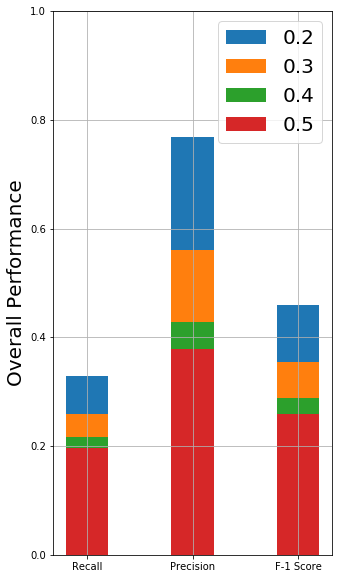

In [36]:
xtick_labels = ["Recall", "Precision", "F-1 Score"]
colour = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9"]
plt.figure(figsize = (5, 10))
for i in range(len(theLastList)):
    for j in range(len(theLastList[0])):
        plt.bar(xtick_labels[i],theLastList[i][j],width = .4, color = colour[j])
plt.ylabel("Overall Performance", fontsize = 20)
plt.ylim(0, 1)
plt.grid()
plt.legend((thresholdForLabel),fontsize = 20, loc = "top right")
plt.savefig(str(thresholdForLabel[0]) + "-" + str(thresholdForLabel[-1]) + "_Non-Tuned.png")

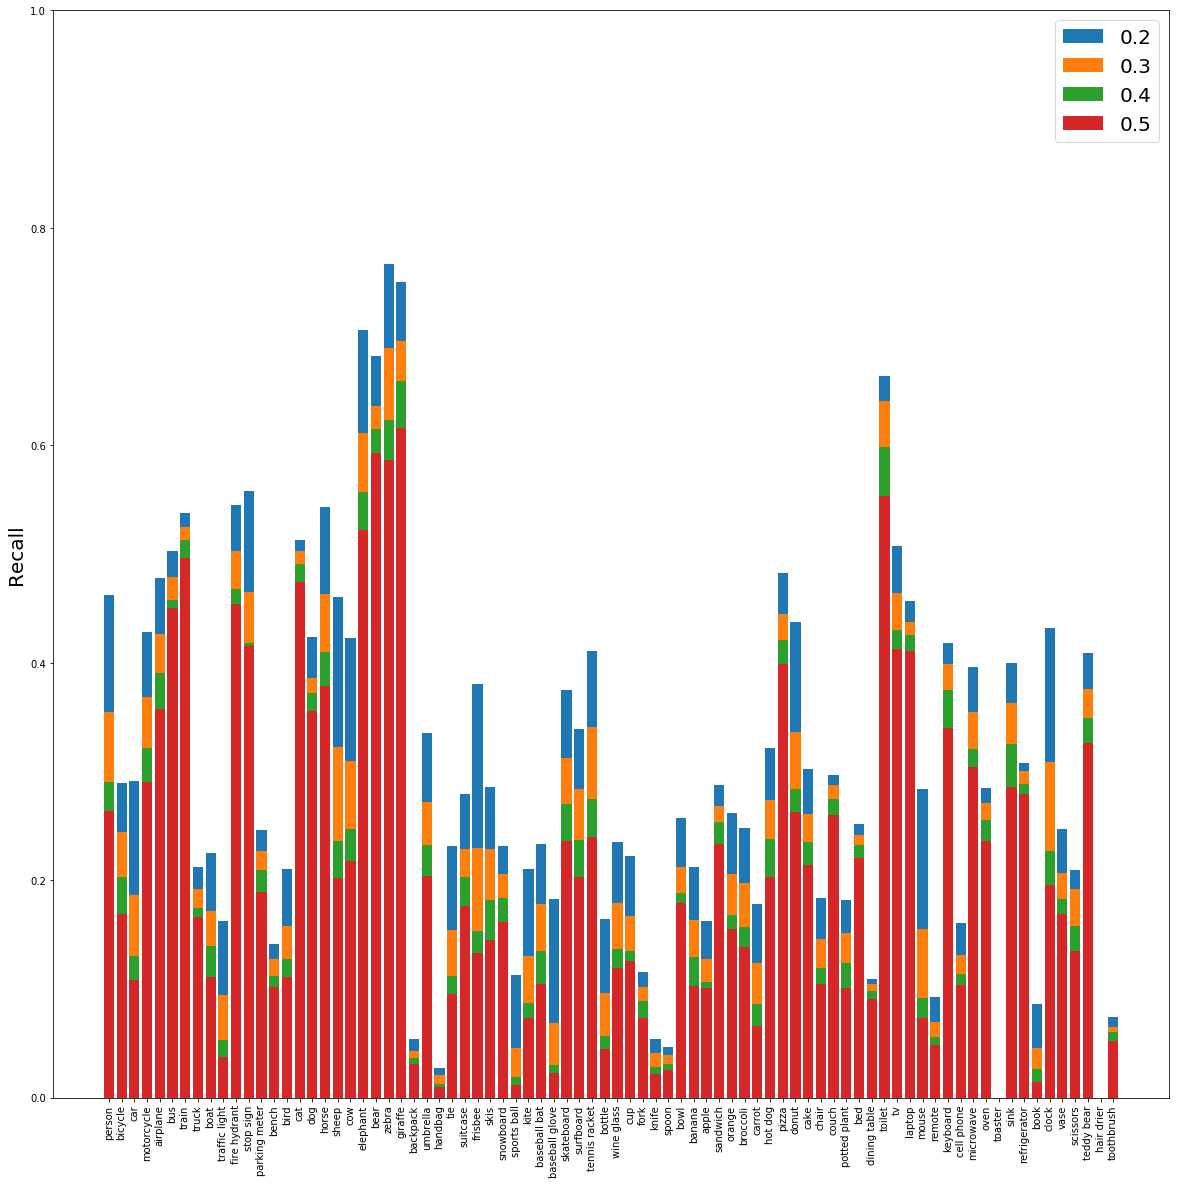

In [37]:
plt.figure(figsize=(20, 20))
plt.xticks([i for i in range(80)],class_names[1:],rotation = 'vertical')
for i in range(len(complete_list[1])):
    plt.bar(class_names[1:],complete_list[0][i])
plt.ylabel("Recall",fontsize = 20)
plt.ylim(0, 1)
plt.legend((thresholdForLabel),fontsize = 20)
plt.savefig(str(thresholdForLabel[0]) + "-" + str(thresholdForLabel[-1]) + "_Recall.png")

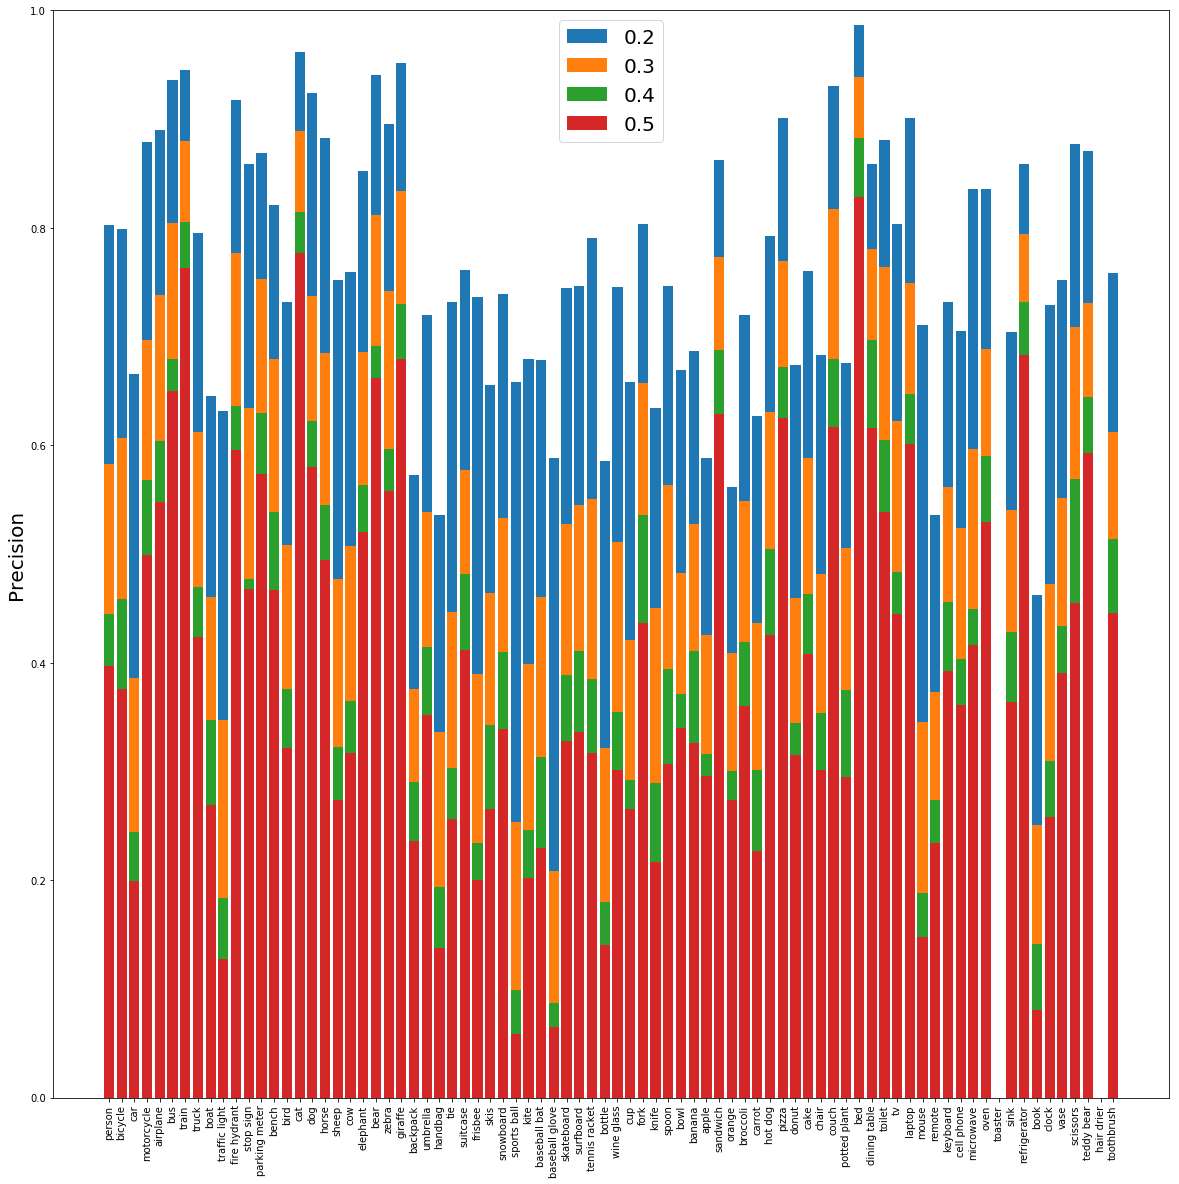

In [38]:
plt.figure(figsize=(20,20))
plt.xticks([i for i in range(80)], class_names[1:], rotation = 'vertical')
for i in range(len(complete_list[1])):
    plt.bar(class_names[1:], complete_list[1][i])
plt.ylabel("Precision", fontsize = 20)
plt.ylim(0, 1)
plt.legend((thresholdForLabel), fontsize = 20)
plt.savefig(str(thresholdForLabel[0]) + "-" + str(thresholdForLabel[-1]) + "_Precision.png")

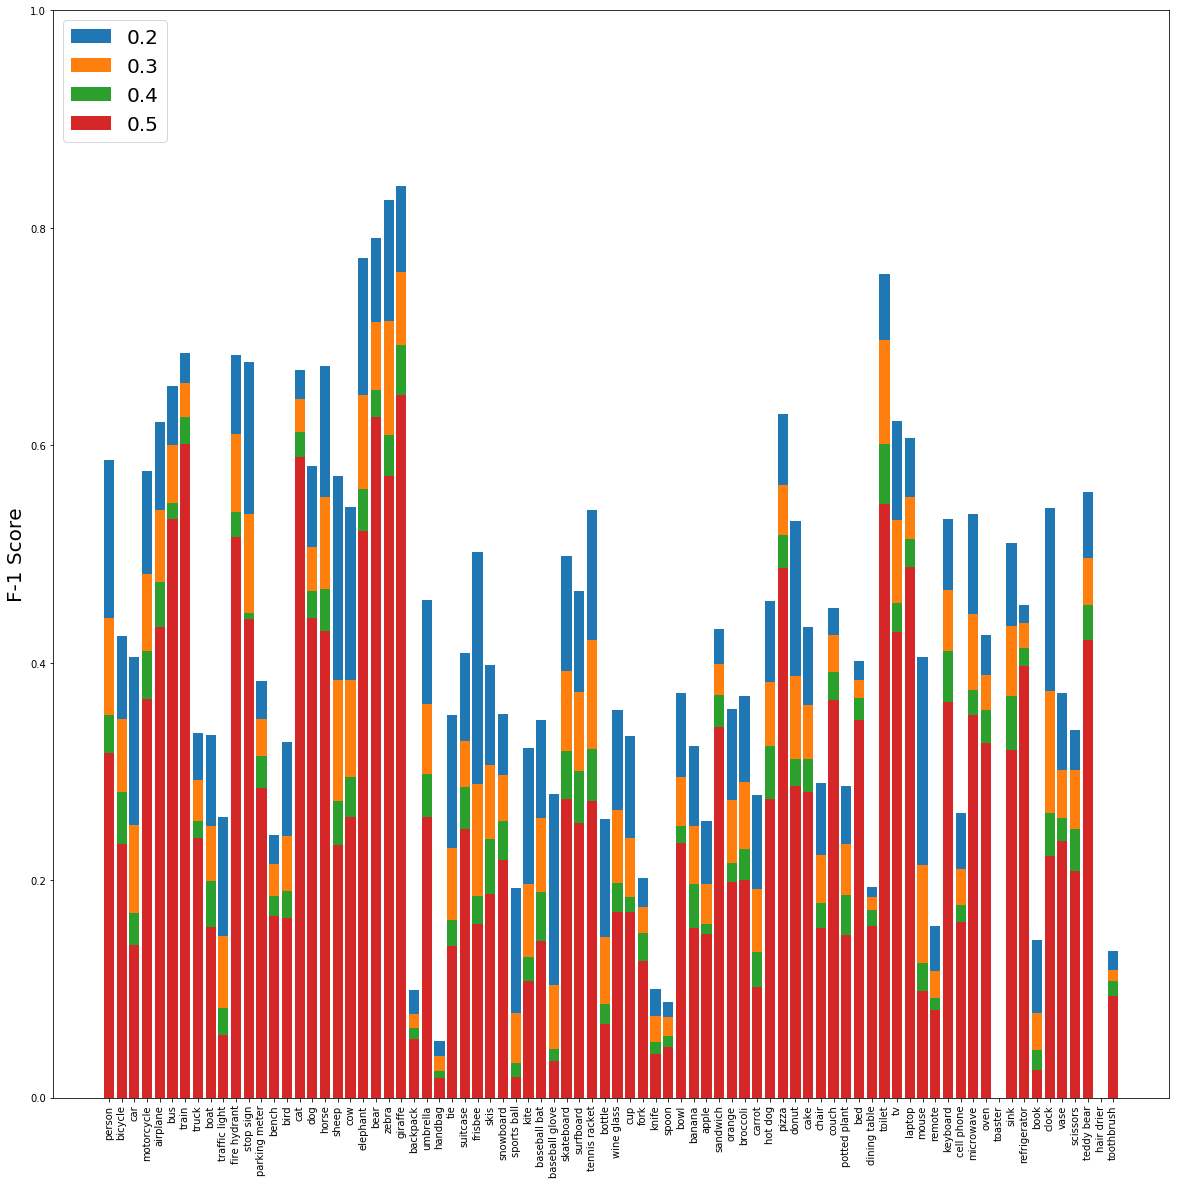

In [39]:
plt.figure(figsize = (20,20))
plt.xticks([i for i in range(80)], class_names[1:], rotation = 'vertical')
for i in range(len(complete_list[2])):
    plt.bar(class_names[1:], complete_list[2][i])
plt.ylabel("F-1 Score", fontsize = 20)
plt.ylim(0, 1)
plt.legend((thresholdForLabel), fontsize = 20)
plt.savefig(str(thresholdForLabel[0]) + "-" + str(thresholdForLabel[-1]) + "_F-1 Score.png")

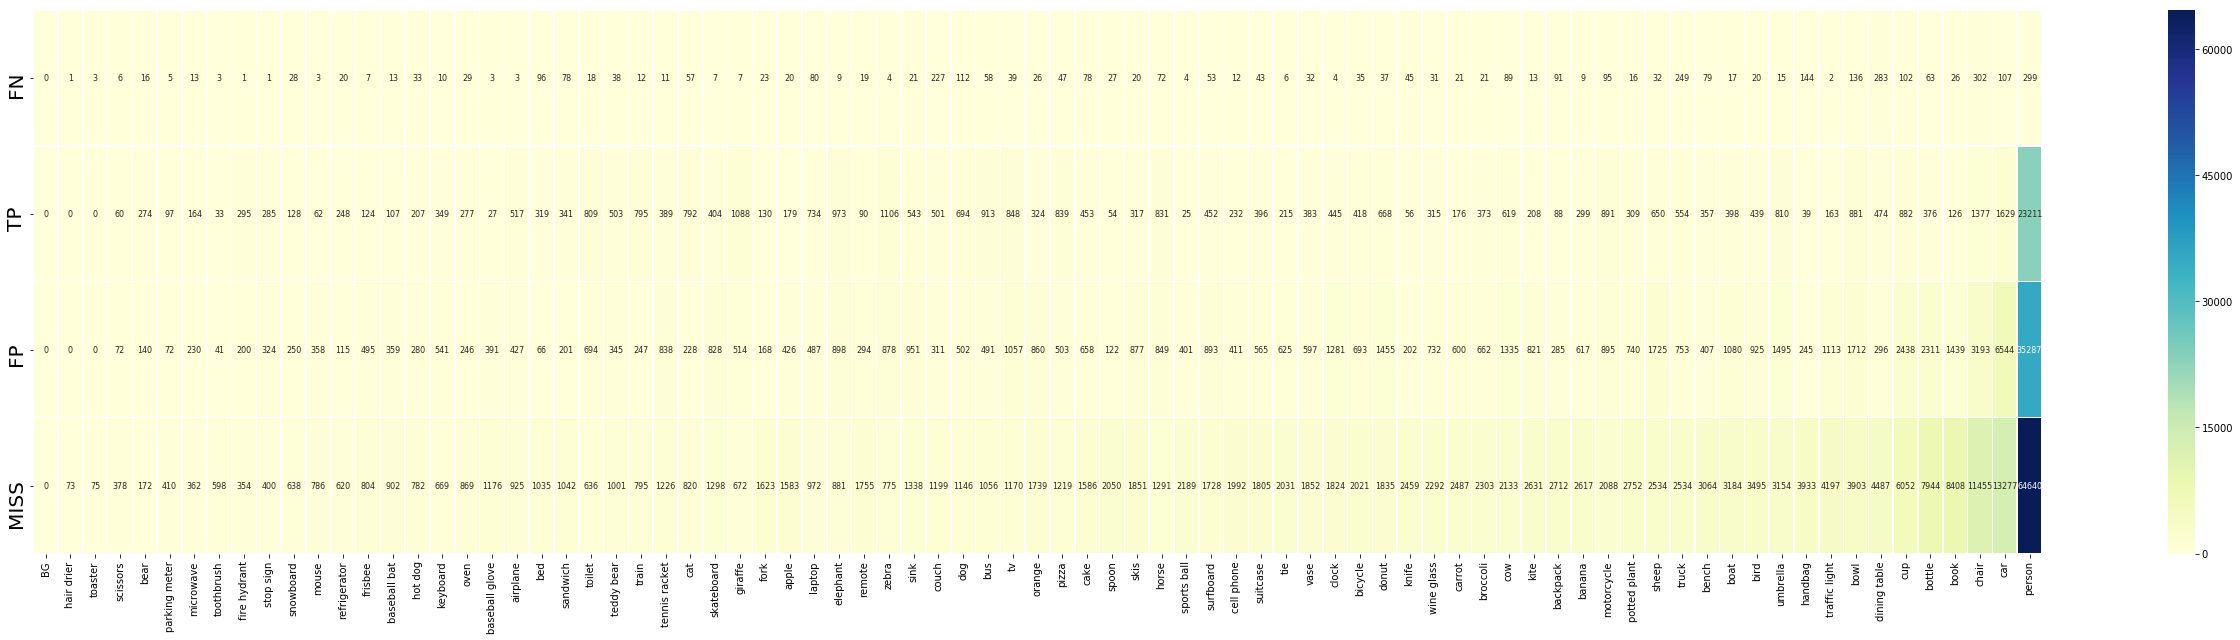

In [40]:
plt.figure(figsize = (45,10))
heatmap = sn.heatmap(real, annot = True,cmap = "YlGnBu", fmt = 'd',annot_kws = {'size':8}, linewidths = .5)
heatmap.yaxis.set_ticklabels(["FN","TP","FP","MISS"], rotation = 90, ha = 'right', fontsize = 20),
plt.savefig("TopPerforming.png")

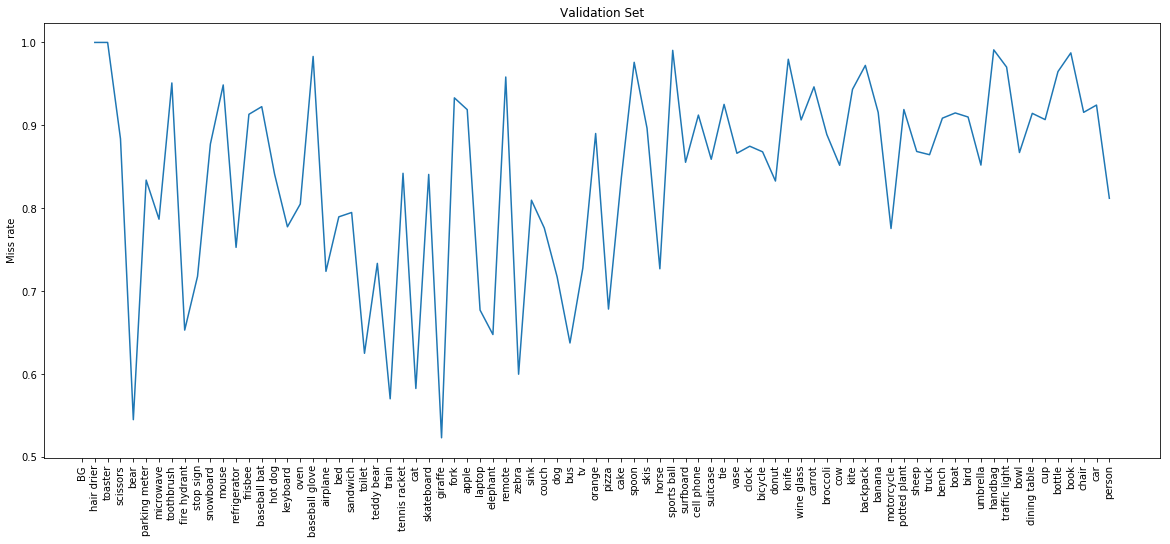

In [41]:
plt.figure(figsize = (20,8))
plt.plot(((real.iloc[[0, 2, 3]].sum()) / (real.iloc[[0, 1, 2, 3]].sum())))
plt.xticks([i for i in range(len(class_names))], real.iloc[:0], rotation = 'vertical');
plt.title("Validation Set")
plt.ylabel("Miss rate")
plt.savefig("Val-Comparison.png")

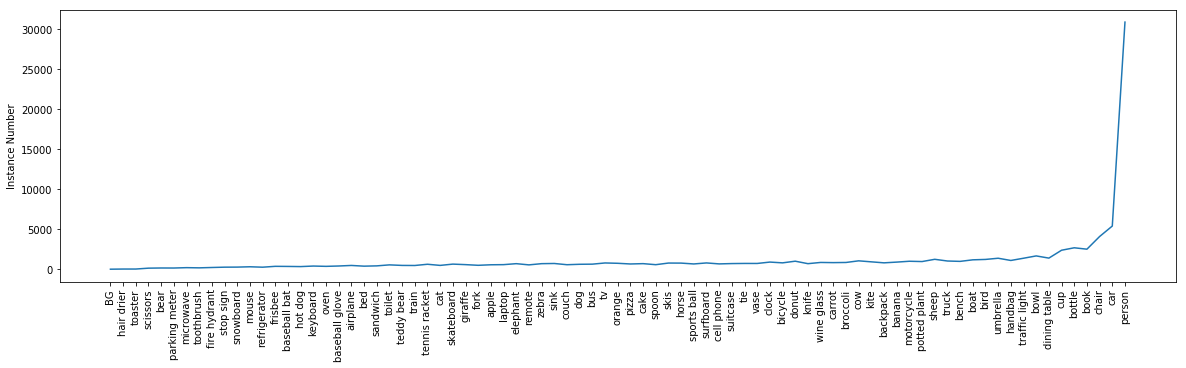

In [42]:
plt.figure(figsize = (20,5))
plt.plot(real.mean());
plt.ylabel("Instance Number")
plt.xticks([i for i in range(len(class_names))], (real.iloc[:0]), rotation = 'vertical');